In [1]:
import sys
import os.path as osp
sys.path.append('/home/wushaogui/MyCodes/')
from my_read_code_tools import *

In [2]:
import json
from logging import root
from os import mkdir
import os.path as ops
from base64 import b64encode

import cv2
import numpy as np

In [3]:
class Mask2Json(object):
    def __init__(self,json_template_path,is_reduce=False):
        '''__init__ [summary]

        Args:
            json_template_path ([type]): [labelme json 的模板]
            is_reduce (bool, optional): [是否减少点集合的点数量]. Defaults to True.
        '''
        self.is_reduce=is_reduce
        #加载json模板
        with open(json_template_path,'r',encoding='utf-8') as fr:
            self.labelme_template=json.load(fr)
    
    def remove_points(self,contour,mindis=2):
        '''remove_points [opencv找到的边点集非常密集，需要通过该函数移除点集中距离小于mindis中的一个点]

        Args:
            contour ([3D ndarray]): [点集]
            mindis (int, optional): [小于该距离的点将被过滤]]. Defaults to 2.

        Returns:
            [2D ndarray]: [已移除靠近点的点集合]
        '''
        new_contour=contour.reshape((contour.shape[0],contour.shape[-1]))
        if (len(new_contour))<6:#点集数量太少，直接返回
            return new_contour
        
        ind=0
        while ind<len(new_contour):
            cur_dis=np.sqrt(np.sum((new_contour[ind+1:]-new_contour[ind])**2,axis=1))
            delnum=0
            for ind_p,_ in enumerate(cur_dis):
                if cur_dis[ind_p]<=mindis:
                    new_contour=np.delete(new_contour,ind+ind_p+1-delnum,0)
                    delnum+=1
            ind+=1
        return new_contour
    
    def append_label_contours_group(self,label_contours_group):
        '''get_label_contours_group 预处理当前标签的contours的结构，以便追加当前contours的层次关系到已有的关系中

        Args:
            label_contours_group (list(list()list())): 某个标签的contours的结构
        '''
        
        # 1.找到已处理标签的contours序号最大值
        max_contours_idx=-1
        contours_group=self.labelme_template['shapes_tree']
        for cur_contours_group in contours_group:
            cur_max_contours_idx=max(sum(cur_contours_group,[]))
            if cur_max_contours_idx>max_contours_idx:
                max_contours_idx=cur_max_contours_idx
        
        # 2.当前标签的contours序号加上最大值
        cur_label_contours_group=[]
        for i in range(len(label_contours_group)):
            for j in range(len(label_contours_group[i])):
                cur_label_contours_group.append([i+max_contours_idx+1 for i in label_contours_group[i][j]])
        
        return cur_label_contours_group
    
    def get_contours_groups(self,mask,labels_idx):
        '''get_contours_groups 获取二值图上不同类别，不同层次的contours

        Args:
            mask (2D array): 某个类别的二值图
            labels_idx (map): 类别与序号的映射关系

        Returns:
            -: 多边形列表、多边形分组、类别列表
        '''
        # 待返回contours层次
        label_contours_group=[]
        
        # 按类别分析多值图的多边形
        mask=mask.astype(np.uint8)
        label_contours,hierarchys = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #原始mask，检测轮廓及层次关系
        
        # 1.找到所有的根节点
        root_contours_group=[[]]
        for idx,hch in enumerate(hierarchys[0]):
            if hch[3]==-1:
                root_contours_group[0].append(idx)
        label_contours_group.append(root_contours_group)
        
        # 2.以跟节点递归找所有子节点
        def get_next_level_contours(contours_group):
            next_level_contours_group=[]
            for idx,hch in enumerate(hierarchys[0]):
                if hch[3] in contours_group:
                    next_level_contours_group.append(idx)
            return next_level_contours_group

        # 使用上一层的contours求取下一层的contours
        for idx,_ in enumerate(label_contours_group):
            cur_contours_gropu=label_contours_group[idx][0]
            next_level_contours_group=get_next_level_contours(cur_contours_gropu)
            while(len(next_level_contours_group)>0):
                label_contours_group[idx].append(next_level_contours_group)
                cur_contours_gropu=next_level_contours_group
                next_level_contours_group=get_next_level_contours(cur_contours_gropu)

        return label_contours,label_contours_group
    
    def mask_to_json(self,image_path,labels_mask,labels_idx,min_points=0,mindis=5,save_json_dir=None):
        '''mask_to_json [生成json文件]

        Args:
            image_path ([str]): 原图文件路径,labelme的json文件包含b64encode编码的原文件，所以需要编码后存储该信息到json
            labels_mask ([list(ndarray)]): 不同类别的mask
            labels_idx (list)：labels_mask对应的标签名
            min_points(int): 点集数量小于该值得mask将被过滤
            save_json_path ([str], optional): 生成的json文件. Defaults to None.

        Returns:
            [bool]: [是否生成成功]
        '''
        # 以下是给模板赋值
        # self.labelme_template['version']='4.5.6'
        # self.labelme_template['flags']={}
        self.labelme_template['shapes']=[]
        self.labelme_template['shapes_tree']=[]
        
        for label_idx,mask in enumerate(labels_mask): 
            mask=mask.astype(np.uint8)
            mask=mask[...,-1] if len(mask.shape)==3 else mask
            
            if np.any(mask):
                # 解析当前标签的二值图，拿到所有的contours及contours的层次关系
                label_contours,label_contours_group=self.get_contours_groups(mask,labels_idx)
                
                # 将contours的层次关系追加到已有的层次关系中，写到self.labelme_template['shapes_tree']上
                cur_label_contours_group=self.append_label_contours_group(label_contours_group)
                if len(cur_label_contours_group)>0:
                    self.labelme_template['shapes_tree'].append(cur_label_contours_group)
            else:
                label_contours=[]
            
            # 遍历当前标签的所有contours，写到self.labelme_template['shapes']上
            for _,contour in enumerate(label_contours):
                new_contour=contour.reshape((contour.shape[0],contour.shape[-1])) #去掉矩阵中间维度1
                if self.is_reduce:
                    # new_contour=self.remove_points(contour,mindis=mindis)#使用自定义方法,移除点集中靠近的点
                    new_contour=cv2.approxPolyDP(contour,2,True) #使用opencv求得近似多边形的点集合
                    new_contour=np.reshape(new_contour,(new_contour.shape[0],new_contour.shape[2]))
                    
                # 过滤后的边点集数量在min_points以上
                if len(new_contour)>=min_points:
                    shape={}
                    # shape['label']='all'
                    shape['label']=labels_idx[label_idx]
                    shape['points']=[]
                    for point in new_contour:
                        assert len(point.shape)==1
                        shape['points'].append(point.tolist())
                    shape['group_id']=None

                    # 不同的形状，不同的解析方法，目前只能区分point，polygon三种类型
                    if len(shape['points'])==1:
                        shape['shape_type']='point'
                    else:
                        shape['shape_type']='polygon'
                    shape['flags']={}

                    self.labelme_template['shapes'].append(shape)
        
        # labelme json的其他信息
        self.labelme_template['imagePath']=image_path.replace('/', '\\')
        # self.labelme_template['imageData']=b64encode(open(image_path, "rb").read()).decode('utf-8')
        self.labelme_template['imageData']=""
        self.labelme_template['imageHeight']=mask.shape[0]
        self.labelme_template['imageWidth']=mask.shape[1]

        # 保存json
        if save_json_dir==None:
            save_json_path=ops.join('./','.'.join(ops.basename(image_path).split('.')[:-1])+'.json')
        else:
            save_json_path=ops.join(save_json_dir,'.'.join(ops.basename(image_path).split('.')[:-1])+'.json')
        json_content=json.dumps(self.labelme_template, ensure_ascii=False, indent=2, separators=(',',': '))
        try:
            with open(save_json_path, 'w+',encoding = 'utf-8') as fw:
                fw.write(json_content)
            return True
        except:
            return False


In [4]:
mask2json=Mask2Json('./labelme4.5.6_template.json',is_reduce=True)

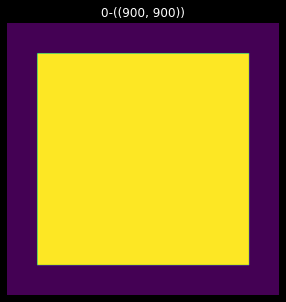

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          800
        ],
        [
          800,
          800
        ],
        [
          800,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    }
  ],
  "imagePath": "demo1.png",
  "imageData": "",
  "imageHeight": 900,
  "imageWidth": 900,
  "shapes_tree": [
    [
      [
        0
      ]
    ]
  ]
}

In [5]:

# 模拟图片
image=np.zeros((900,900),np.uint8)
mask=np.zeros((900,900),np.uint8)

# 一个目标
cv2.rectangle(mask,(100,100),(800,800),255,-1)

show_images([mask])
image_path='demo1.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}

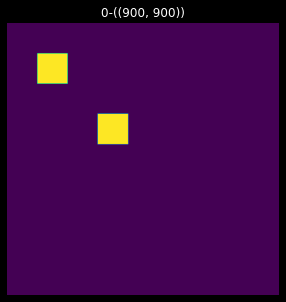

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          300,
          300
        ],
        [
          300,
          400
        ],
        [
          400,
          400
        ],
        [
          400,
          300
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          200
        ],
        [
          200,
          200
        ],
        [
          200,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    }
  ],
  "imagePath": "demo2.png",
  "imageData": "",
  "imageHeight": 900,
  "imageWidth": 900,
  "shapes_tree": [
    [
      [
        0,
        1
      ]
    ]
  ]
}

In [6]:
# 模拟图片
image=np.zeros((900,900),np.uint8)
mask=np.zeros((900,900),np.uint8)

# 2个同类目标
cv2.rectangle(mask,(100,100),(200,200),255,-1)
cv2.rectangle(mask,(300,300),(400,400),255,-1)

show_images([mask])
image_path='demo2.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}

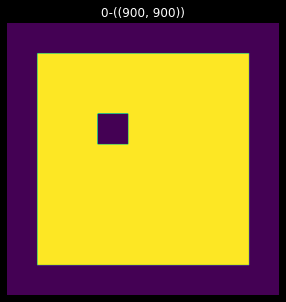

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          800
        ],
        [
          800,
          800
        ],
        [
          800,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊印",
      "points": [
        [
          299,
          300
        ],
        [
          400,
          299
        ],
        [
          401,
          400
        ],
        [
          300,
          401
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    }
  ],
  "imagePath": "demo3.png",
  "imageData": "",
  "imageHeight": 900,
  "imageWidth": 900,
  "shapes_tree": [
    [
      [
        0
      ],
      [
        1
      ]
    ]
  ]
}

In [7]:
# 模拟图片
image=np.zeros((900,900),np.uint8)
mask=np.zeros((900,900),np.uint8)

# 1个目标，有空洞
cv2.rectangle(mask,(100,100),(800,800),255,-1)
cv2.rectangle(mask,(300,300),(400,400),0,-1)

show_images([mask])
image_path='demo3.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}

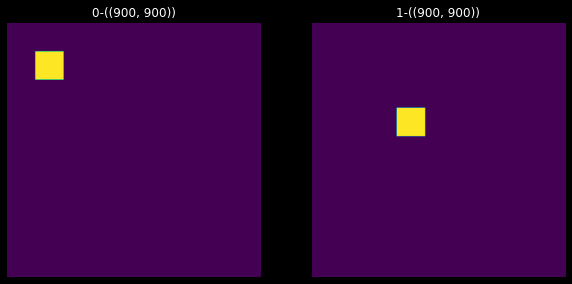

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          200
        ],
        [
          200,
          200
        ],
        [
          200,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊穿",
      "points": [
        [
          300,
          300
        ],
        [
          300,
          400
        ],
        [
          400,
          400
        ],
        [
          400,
          300
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    }
  ],
  "imagePath": "demo4.png",
  "imageData": "",
  "imageHeight": 900,
  "imageWidth": 900,
  "shapes_tree": [
    [
      [
        0
      ]
    ],
    [
      [
        1
      ]
    ]
  ]
}

In [8]:
# 模拟图片
image=np.zeros((900,900),np.uint8)
mask1=np.zeros((900,900),np.uint8)
mask2=np.zeros((900,900),np.uint8)

# 2个目标，不同类
cv2.rectangle(mask1,(100,100),(200,200),255,-1)
cv2.rectangle(mask2,(300,300),(400,400),200,-1)

show_images([mask1,mask2])
image_path='demo4.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask1,mask2],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}

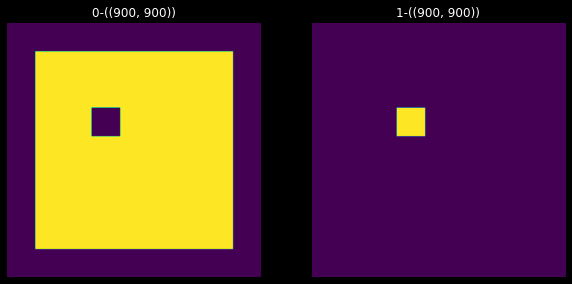

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          800
        ],
        [
          800,
          800
        ],
        [
          800,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊印",
      "points": [
        [
          299,
          300
        ],
        [
          400,
          299
        ],
        [
          401,
          400
        ],
        [
          300,
          401
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊穿",
      "points": [
        [
          300,
          300
        ],
        [
          300,
          400
        ],
        [
          400,
          400
        ],
        [
          400,
          300
        ]
      ],
      "group_id": null,
    

In [9]:
# 模拟图片
image=np.zeros((900,900),np.uint8)
mask1=np.zeros((900,900),np.uint8)
mask2=np.zeros((900,900),np.uint8)

# 2个目标，不同类，其中一个有空洞
cv2.rectangle(mask1,(100,100),(800,800),255,-1)
cv2.rectangle(mask1,(300,300),(400,400),0,-1)
cv2.rectangle(mask2,(300,300),(400,400),200,-1)

show_images([mask1,mask2])
image_path='demo4.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask1,mask2],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}

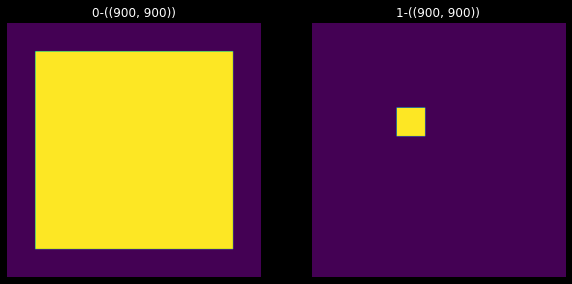

{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "焊印",
      "points": [
        [
          100,
          100
        ],
        [
          100,
          800
        ],
        [
          800,
          800
        ],
        [
          800,
          100
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "焊穿",
      "points": [
        [
          300,
          300
        ],
        [
          300,
          400
        ],
        [
          400,
          400
        ],
        [
          400,
          300
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    }
  ],
  "imagePath": "demo4.png",
  "imageData": "",
  "imageHeight": 900,
  "imageWidth": 900,
  "shapes_tree": [
    [
      [
        0
      ]
    ],
    [
      [
        1
      ]
    ]
  ]
}

In [10]:
# 模拟图片
image=np.zeros((900,900),np.uint8)
mask1=np.zeros((900,900),np.uint8)
mask2=np.zeros((900,900),np.uint8)

# 2个目标，不同类，其中一个有空洞
cv2.rectangle(mask1,(100,100),(800,800),255,-1)
cv2.rectangle(mask2,(300,300),(400,400),200,-1)

show_images([mask1,mask2])
image_path='demo4.png'
cv2.imwrite(image_path,image)
labels_idx=['焊印','焊穿','爆点','侧面焊印','焊穿爆点']

mask2json.mask_to_json(image_path,[mask1,mask2],labels_idx,save_json_dir='./')
!cat {image_path.replace('png', 'json')}